# Multi-Critic Unlearning Evaluation (Lambda=1.0)

Evaluate frozen multi-critic unlearning results

**Date:** November 7, 2025

**Model:** `outputs/p2/unlearn_multicritic_lambda1/best_model.pt`

**Comparison:**
- Baseline: AUC = 0.951
- Best single-critic (Lambda=0.5): AUC = 0.906
- Retrain floor: AUC = 0.864
- Target band: [0.834, 0.894]

**Approach:**
1. Load unlearned VAE
2. Train post-hoc attacker (100 epochs)
3. Compute two-negative conditioned AUC (F vs U, F vs R)
4. Compare to benchmarks
5. Visualize ROC curves

In [1]:
import sys
sys.path.append('src')

import json
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from attacker_eval import evaluate_with_conditioning, compute_confidence_interval
from utils import set_global_seed

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

In [2]:
set_global_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Splits

In [3]:
DATA_PATH = "data/adata_processed.h5ad"
SPLIT_PATH = "outputs/p1/split_structured.json"
UNLEARNED_CHECKPOINT = "outputs/p2/unlearn_multicritic_lambda1/best_model.pt"

adata = sc.read_h5ad(DATA_PATH)
print(f"Data shape: {adata.shape}")

with open(SPLIT_PATH, 'r') as f:
    splits = json.load(f)

forget_indices = np.array(splits['forget_indices'])
retain_indices = np.array(splits['retain_indices'])
unseen_indices = np.array(splits['unseen_indices'])

print(f"\nSplit sizes:")
print(f"  Forget: {len(forget_indices)}")
print(f"  Retain: {len(retain_indices)}")
print(f"  Unseen: {len(unseen_indices)}")

Data shape: (33088, 2000)

Split sizes:
  Forget: 30
  Retain: 28094
  Unseen: 4964


## 2. Load Unlearned VAE

In [4]:
checkpoint = torch.load(UNLEARNED_CHECKPOINT, map_location=device)

vae = VAE(
    input_dim=adata.n_vars,
    latent_dim=32,
    hidden_dims=[1024, 512, 128],
    likelihood='nb',
    dropout=0.1,
    use_layer_norm=True
).to(device)

vae.load_state_dict(checkpoint['vae_state_dict'])
vae.eval()

print(f"Loaded unlearned VAE from: {UNLEARNED_CHECKPOINT}")
print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"EMA privacy: {checkpoint.get('ema_privacy', 'N/A')}")

Loaded unlearned VAE from: outputs/p2/unlearn_multicritic_lambda1/best_model.pt
Epoch: 48
EMA privacy: 0.22937718725437936


## 3. Extract VAE Features

In [5]:
def create_feature_dataset(vae, adata, indices, device, batch_size=256):
    """Extract VAE features for attacker training."""
    vae.eval()
    all_features = []
    
    for i in range(0, len(indices), batch_size):
        batch_idx = indices[i:i+batch_size]
        X = torch.FloatTensor(
            adata.X[batch_idx].toarray() if hasattr(adata.X[batch_idx], 'toarray') 
            else adata.X[batch_idx]
        ).to(device)
        library_size = torch.FloatTensor(X.sum(dim=1, keepdim=True)).to(device)
        
        with torch.no_grad():
            vae_feats = extract_vae_features(vae, X, library_size, device)
            attack_feats = build_attack_features(vae_feats)
            all_features.append(attack_feats.cpu())
    
    return torch.cat(all_features, dim=0)

print("Extracting features...")
forget_features = create_feature_dataset(vae, adata, forget_indices, device)
retain_features = create_feature_dataset(vae, adata, retain_indices, device)
unseen_features = create_feature_dataset(vae, adata, unseen_indices, device)

print(f"Forget features: {forget_features.shape}")
print(f"Retain features: {retain_features.shape}")
print(f"Unseen features: {unseen_features.shape}")

Extracting features...
Forget features: torch.Size([30, 69])
Retain features: torch.Size([28094, 69])
Unseen features: torch.Size([4964, 69])


## 4. Train Post-Hoc Attacker

In [6]:
def train_attacker(pos_features, neg_features, input_dim, device, epochs=100, lr=0.001):
    """Train attacker to distinguish positive (1) from negative (0)."""
    # Create dataset
    pos_labels = torch.ones(len(pos_features), 1)
    neg_labels = torch.zeros(len(neg_features), 1)
    
    X = torch.cat([pos_features, neg_features], dim=0)
    y = torch.cat([pos_labels, neg_labels], dim=0)
    
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    
    # Initialize attacker
    attacker = MLPAttacker(
        input_dim=input_dim,
        hidden_dims=[256, 256],
        dropout=0.3,
        use_spectral_norm=True
    ).to(device)
    
    optimizer = optim.Adam(attacker.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Train
    attacker.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            logits = attacker(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")
    
    attacker.eval()
    return attacker

# Train attacker on Forget (pos) vs Retain+Unseen (neg)
print("\n=== Training Post-Hoc Attacker (F vs R+U) ===")
input_dim = forget_features.shape[1]
neg_features = torch.cat([retain_features, unseen_features], dim=0)

attacker = train_attacker(forget_features, neg_features, input_dim, device, epochs=100)


=== Training Post-Hoc Attacker (F vs R+U) ===
Epoch 20/100 - Loss: 0.0065
Epoch 40/100 - Loss: 0.0043
Epoch 60/100 - Loss: 0.0031
Epoch 80/100 - Loss: 0.0030
Epoch 100/100 - Loss: 0.0028


## 5. Two-Negative Conditioned Evaluation

In [7]:
def evaluate_binary(attacker, pos_features, neg_features, device):
    """Evaluate attacker on binary classification task."""
    attacker.eval()
    
    with torch.no_grad():
        pos_logits = attacker(pos_features.to(device)).cpu().numpy()
        neg_logits = attacker(neg_features.to(device)).cpu().numpy()
    
    pos_scores = torch.sigmoid(torch.FloatTensor(pos_logits)).numpy()
    neg_scores = torch.sigmoid(torch.FloatTensor(neg_logits)).numpy()
    
    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    y_score = np.concatenate([pos_scores, neg_scores])
    
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    return auc, fpr, tpr

# F vs U (matched negatives)
auc_f_vs_u, fpr_f_vs_u, tpr_f_vs_u = evaluate_binary(attacker, forget_features, unseen_features, device)

# F vs R (matched negatives)
auc_f_vs_r, fpr_f_vs_r, tpr_f_vs_r = evaluate_binary(attacker, forget_features, retain_features, device)

# Two-negative average
auc_two_neg = (auc_f_vs_u + auc_f_vs_r) / 2

print(f"\n=== Multi-Critic Lambda=1.0 Results ===")
print(f"AUC (F vs U): {auc_f_vs_u:.4f}")
print(f"AUC (F vs R): {auc_f_vs_r:.4f}")
print(f"AUC (Two-Negative): {auc_two_neg:.4f}")
print(f"\n=== Comparison ===")
print(f"Baseline:           0.951")
print(f"Single-Critic (λ=0.5): 0.906")
print(f"Multi-Critic (λ=1.0):  {auc_two_neg:.3f}")
print(f"Retrain Floor:      0.864")
print(f"Target Band:        [0.834, 0.894]")
print(f"\nGap to floor: {auc_two_neg - 0.864:+.3f}")
print(f"Within target: {'YES' if 0.834 <= auc_two_neg <= 0.894 else 'NO'}")


=== Multi-Critic Lambda=1.0 Results ===
AUC (F vs U): 0.9952
AUC (F vs R): 0.9954
AUC (Two-Negative): 0.9953

=== Comparison ===
Baseline:           0.951
Single-Critic (λ=0.5): 0.906
Multi-Critic (λ=1.0):  0.995
Retrain Floor:      0.864
Target Band:        [0.834, 0.894]

Gap to floor: +0.131
Within target: NO


## 6. TPR at Low FPR

In [8]:
def tpr_at_fpr(fpr, tpr, target_fpr):
    """Get TPR at target FPR."""
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

# F vs U
tpr_1pct_u = tpr_at_fpr(fpr_f_vs_u, tpr_f_vs_u, 0.01)
tpr_01pct_u = tpr_at_fpr(fpr_f_vs_u, tpr_f_vs_u, 0.001)

# F vs R
tpr_1pct_r = tpr_at_fpr(fpr_f_vs_r, tpr_f_vs_r, 0.01)
tpr_01pct_r = tpr_at_fpr(fpr_f_vs_r, tpr_f_vs_r, 0.001)

print(f"\n=== TPR at Low FPR ===")
print(f"F vs U:")
print(f"  TPR @ 1% FPR:  {tpr_1pct_u:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_01pct_u:.4f}")
print(f"\nF vs R:")
print(f"  TPR @ 1% FPR:  {tpr_1pct_r:.4f}")
print(f"  TPR @ 0.1% FPR: {tpr_01pct_r:.4f}")


=== TPR at Low FPR ===
F vs U:
  TPR @ 1% FPR:  0.9333
  TPR @ 0.1% FPR: 0.7333

F vs R:
  TPR @ 1% FPR:  0.9333
  TPR @ 0.1% FPR: 0.8000


## 7. Visualizations

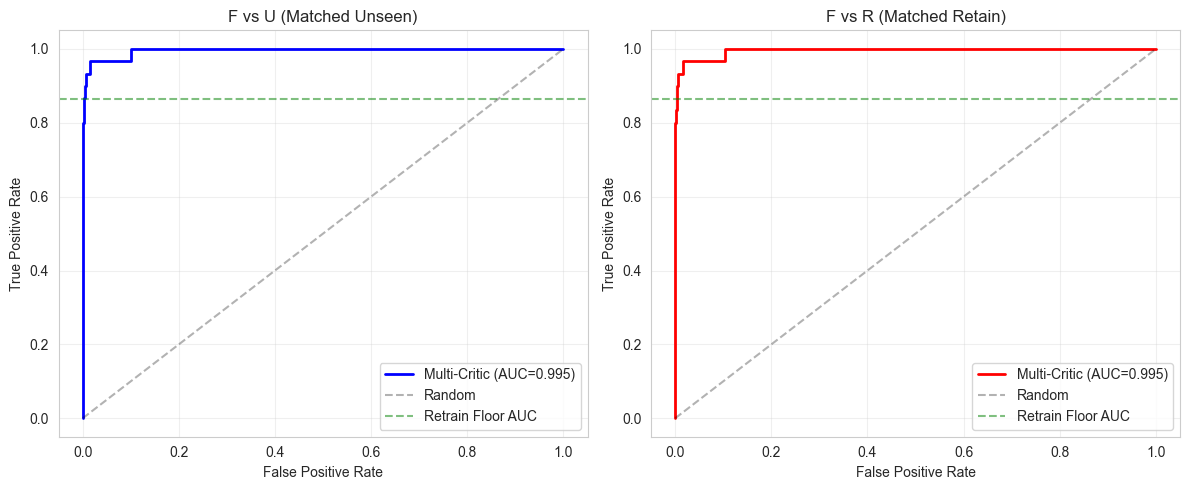

Saved: outputs/p2/multicritic_lambda1_roc.png


In [9]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F vs U
axes[0].plot(fpr_f_vs_u, tpr_f_vs_u, 'b-', linewidth=2, label=f'Multi-Critic (AUC={auc_f_vs_u:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[0].axhline(y=0.864, color='g', linestyle='--', alpha=0.5, label='Retrain Floor AUC')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('F vs U (Matched Unseen)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F vs R
axes[1].plot(fpr_f_vs_r, tpr_f_vs_r, 'r-', linewidth=2, label=f'Multi-Critic (AUC={auc_f_vs_r:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1].axhline(y=0.864, color='g', linestyle='--', alpha=0.5, label='Retrain Floor AUC')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('F vs R (Matched Retain)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/multicritic_lambda1_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/multicritic_lambda1_roc.png")

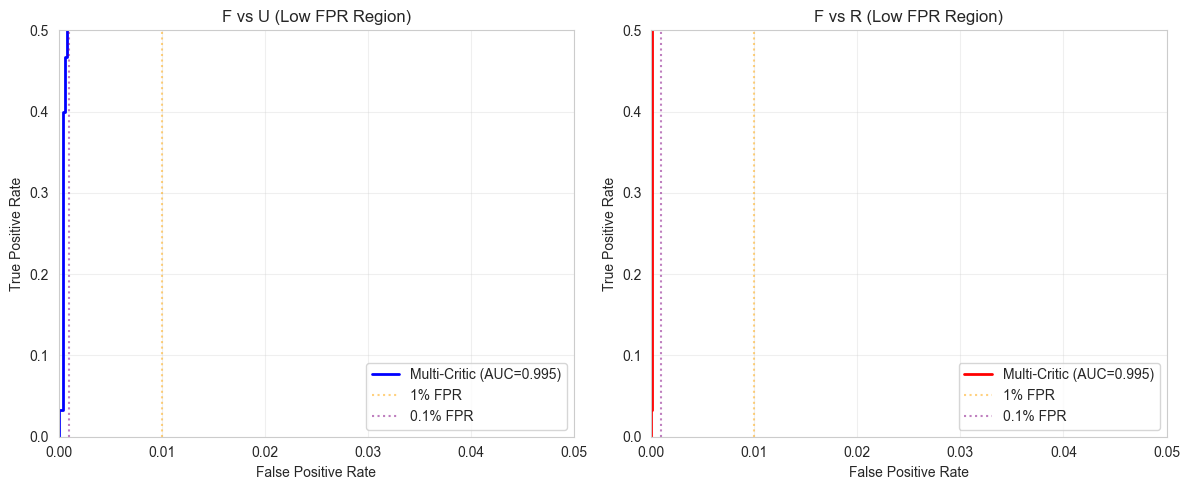

Saved: outputs/p2/multicritic_lambda1_roc_zoomed.png


In [10]:
# Zoomed ROC (low FPR)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F vs U (zoomed)
axes[0].plot(fpr_f_vs_u, tpr_f_vs_u, 'b-', linewidth=2, label=f'Multi-Critic (AUC={auc_f_vs_u:.3f})')
axes[0].axvline(x=0.01, color='orange', linestyle=':', alpha=0.5, label='1% FPR')
axes[0].axvline(x=0.001, color='purple', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('F vs U (Low FPR Region)')
axes[0].set_xlim([0, 0.05])
axes[0].set_ylim([0, 0.5])
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F vs R (zoomed)
axes[1].plot(fpr_f_vs_r, tpr_f_vs_r, 'r-', linewidth=2, label=f'Multi-Critic (AUC={auc_f_vs_r:.3f})')
axes[1].axvline(x=0.01, color='orange', linestyle=':', alpha=0.5, label='1% FPR')
axes[1].axvline(x=0.001, color='purple', linestyle=':', alpha=0.5, label='0.1% FPR')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('F vs R (Low FPR Region)')
axes[1].set_xlim([0, 0.05])
axes[1].set_ylim([0, 0.5])
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/multicritic_lambda1_roc_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/multicritic_lambda1_roc_zoomed.png")

## 8. Save Results

In [11]:
results = {
    'model': 'multi_critic_lambda1',
    'checkpoint': UNLEARNED_CHECKPOINT,
    'auc_f_vs_u': float(auc_f_vs_u),
    'auc_f_vs_r': float(auc_f_vs_r),
    'auc_two_negative': float(auc_two_neg),
    'tpr_1pct_fpr_u': float(tpr_1pct_u),
    'tpr_01pct_fpr_u': float(tpr_01pct_u),
    'tpr_1pct_fpr_r': float(tpr_1pct_r),
    'tpr_01pct_fpr_r': float(tpr_01pct_r),
    'benchmarks': {
        'baseline': 0.951,
        'single_critic_lambda05': 0.906,
        'retrain_floor': 0.864,
        'target_lower': 0.834,
        'target_upper': 0.894
    },
    'within_target': bool(0.834 <= auc_two_neg <= 0.894),
    'gap_to_floor': float(auc_two_neg - 0.864)
}

output_path = Path('outputs/p2/multicritic_lambda1_results.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {output_path}")
print(json.dumps(results, indent=2))


Results saved to: outputs/p2/multicritic_lambda1_results.json
{
  "model": "multi_critic_lambda1",
  "checkpoint": "outputs/p2/unlearn_multicritic_lambda1/best_model.pt",
  "auc_f_vs_u": 0.9951651893634166,
  "auc_f_vs_r": 0.9953797963978074,
  "auc_two_negative": 0.995272492880612,
  "tpr_1pct_fpr_u": 0.9333333333333333,
  "tpr_01pct_fpr_u": 0.7333333333333333,
  "tpr_1pct_fpr_r": 0.9333333333333333,
  "tpr_01pct_fpr_r": 0.8,
  "benchmarks": {
    "baseline": 0.951,
    "single_critic_lambda05": 0.906,
    "retrain_floor": 0.864,
    "target_lower": 0.834,
    "target_upper": 0.894
  },
  "within_target": false,
  "gap_to_floor": 0.13127249288061205
}
